# 👖 Variational Autoencoders - Fashion-MNIST

In this notebook, we'll walk through the steps required to train your own autoencoder on the fashion MNIST dataset.

The code has been adapted from the excellent [VAE tutorial](https://keras.io/examples/generative/vae/) created by Francois Chollet, available on the Keras website.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from scipy.stats import norm


## 0. Parameters <a name="parameters"></a>

In [2]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500
LEARNING_RATE = 0.0005

## 1. Prepare the data <a name="prepare"></a>

In [28]:
# Load the data
import numpy as np
from PIL import Image

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = np.array(imgs).astype("float32") / 255.0
    imgs = np.pad(imgs, ((2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

transform = transforms.Compose([
    transforms.Lambda(preprocess),
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Split the dataset into training and validation sets
train_size = int((1 - VALIDATION_SPLIT) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

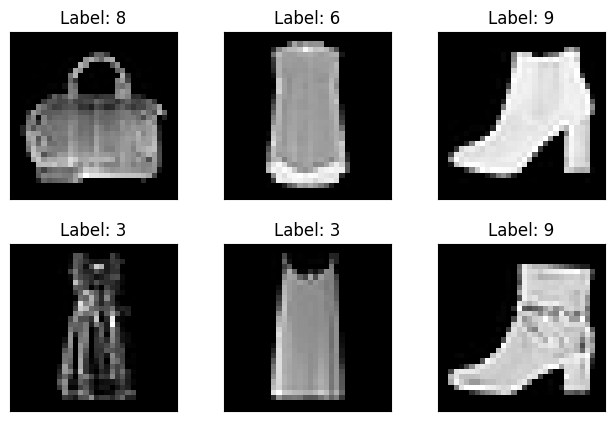

In [29]:
# Show some items of clothing from the training set
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title(f"Label: {example_targets[i]}")
    plt.xticks([])
    plt.yticks([])
plt.show()

## 3. Train the variational autoencoder <a name="train"></a>

In [34]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        return reconstruction, z_mean, z_log_var

def vae_loss(recon_x, x, mu, logvar, beta):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD


class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_log_var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        z_mean = self.fc2_mean(h)
        z_log_var = self.fc2_log_var(h)
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std)
        z = z_mean + eps * std
        return z_mean, z_log_var, z

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        reconstruction = torch.sigmoid(self.fc2(h))
        return reconstruction

input_dim = IMAGE_SIZE * IMAGE_SIZE
hidden_dim = 256
latent_dim = EMBEDDING_DIM
output_dim = IMAGE_SIZE * IMAGE_SIZE

encoder = Encoder(input_dim, hidden_dim, latent_dim)
decoder = Decoder(latent_dim, hidden_dim, output_dim)
vae = VAE(encoder, decoder)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE)

def train(epochs):
    vae.train()
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view(-1, IMAGE_SIZE*IMAGE_SIZE)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data)
            loss = vae_loss(recon_batch, data, mu, logvar, BETA)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item() / len(data):.6f}')
        print(f'====> Epoch: {epoch+1}, Average loss: {train_loss / len(train_loader.dataset):.4f}')

train(EPOCHS)

Epoch 1/5, Batch 0/480, Loss: 735.881250
Epoch 1/5, Batch 100/480, Loss: 422.329883
Epoch 1/5, Batch 200/480, Loss: 390.448711
Epoch 1/5, Batch 300/480, Loss: 383.210508
Epoch 1/5, Batch 400/480, Loss: 389.637930
====> Epoch: 1, Average loss: 413.2105
Epoch 2/5, Batch 0/480, Loss: 385.777969
Epoch 2/5, Batch 100/480, Loss: 381.583086
Epoch 2/5, Batch 200/480, Loss: 384.618945
Epoch 2/5, Batch 300/480, Loss: 380.943477
Epoch 2/5, Batch 400/480, Loss: 387.418242
====> Epoch: 2, Average loss: 386.1244
Epoch 3/5, Batch 0/480, Loss: 385.619766
Epoch 3/5, Batch 100/480, Loss: 375.076758
Epoch 3/5, Batch 200/480, Loss: 390.044180
Epoch 3/5, Batch 300/480, Loss: 383.358789
Epoch 3/5, Batch 400/480, Loss: 382.131953
====> Epoch: 3, Average loss: 385.3518
Epoch 4/5, Batch 0/480, Loss: 385.901992
Epoch 4/5, Batch 100/480, Loss: 378.383516
Epoch 4/5, Batch 200/480, Loss: 385.654258
Epoch 4/5, Batch 300/480, Loss: 397.274219
Epoch 4/5, Batch 400/480, Loss: 379.183477
====> Epoch: 4, Average loss: 3

## 4. Embed using the encoder <a name="encode"></a>

In [42]:
# Encode the example images
vae.eval()
with torch.no_grad():
    example_images, example_labels = next(iter(test_loader))
    example_images = example_images.view(-1,IMAGE_SIZE*IMAGE_SIZE)
    z_mean, z_log_var, z = vae.encoder(example_images)
    z = z.numpy()

# Some examples of the embeddings
print(z[:10])

[[ 0.6450082  -2.0201476 ]
 [ 1.6203476  -0.10192824]
 [ 1.2208788   0.47905248]
 [-1.3956711   0.2519108 ]
 [-1.2608778  -0.3997263 ]
 [ 1.1111338  -0.65939146]
 [ 0.4029977  -0.7775365 ]
 [ 1.0278853  -0.06712884]
 [ 1.3763542  -0.15094756]
 [-1.0344741  -0.0740985 ]]


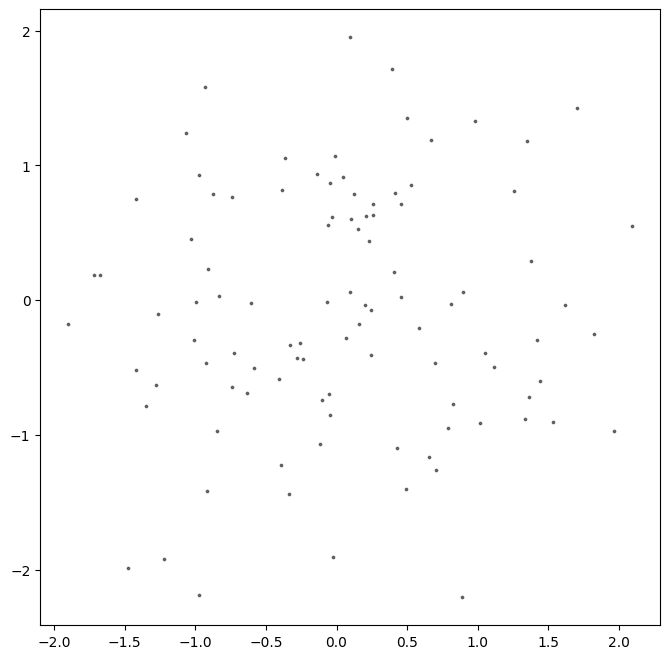

In [37]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

## 5. Generate using the decoder <a name="decode"></a>

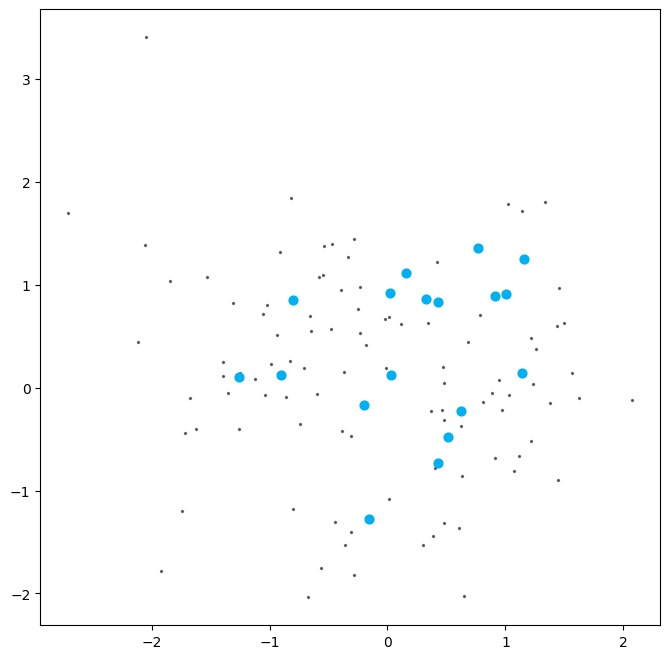

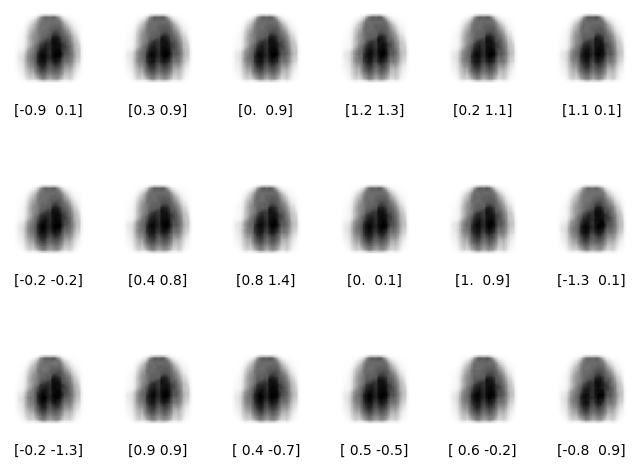

In [48]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, EMBEDDING_DIM))
z_sample = torch.from_numpy(z_sample).float()

# Decode the sampled points
vae.eval()
with torch.no_grad():
    reconstructions = vae.decoder(z_sample).numpy().reshape(-1, 1, IMAGE_SIZE, IMAGE_SIZE)

# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :].numpy(), 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, 0, :, :], cmap="Greys")

## 6. Explore the latent space <a name="explore"></a>

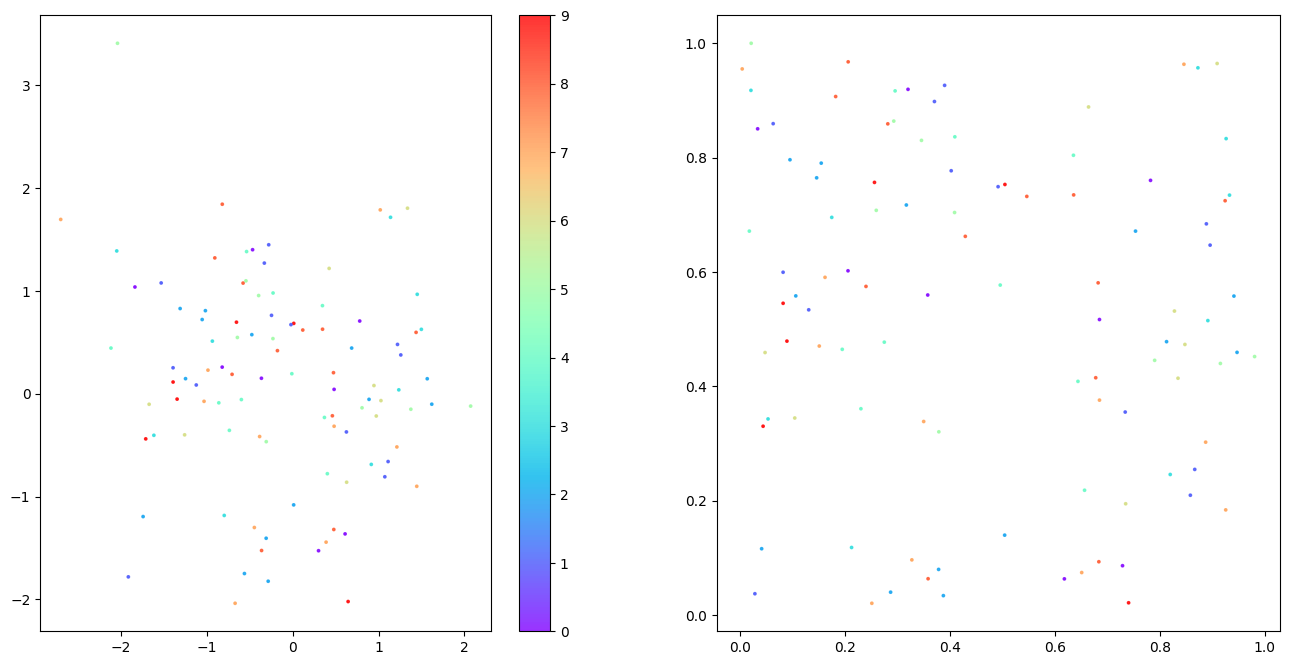

In [46]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
p = norm.cdf(z)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

In [44]:
example_labels.shape

torch.Size([100])

| ID | Clothing Label |
| :- | :- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

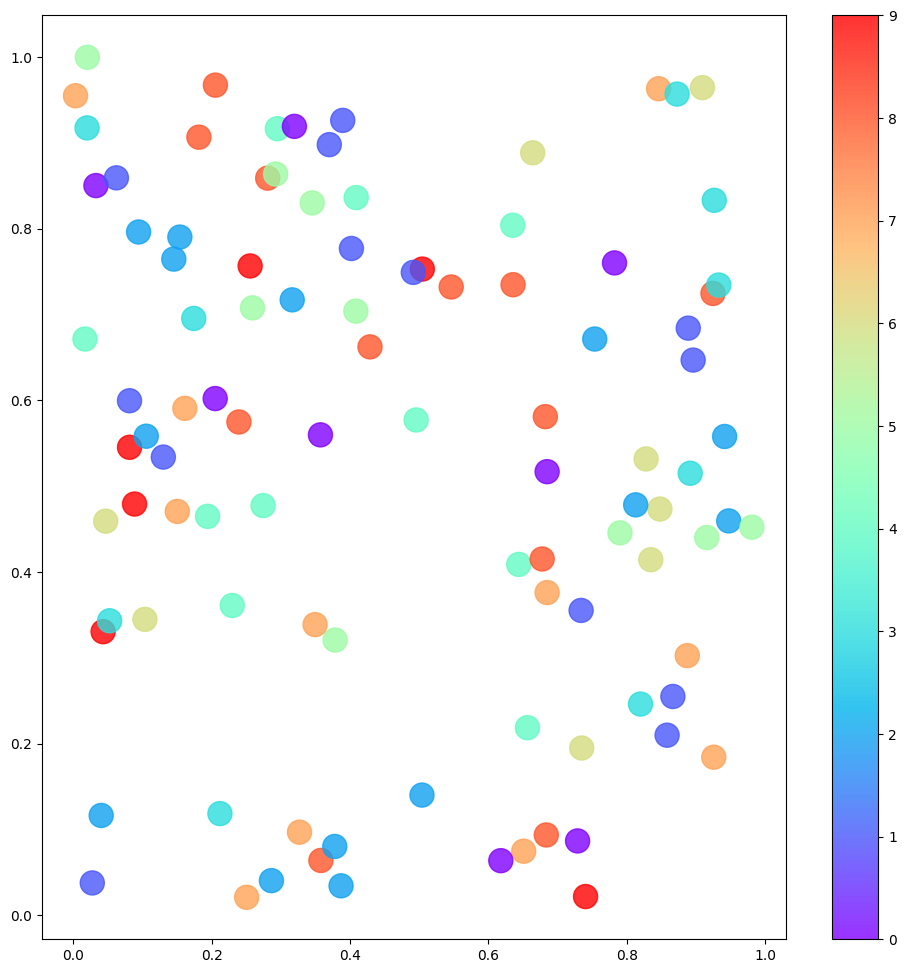

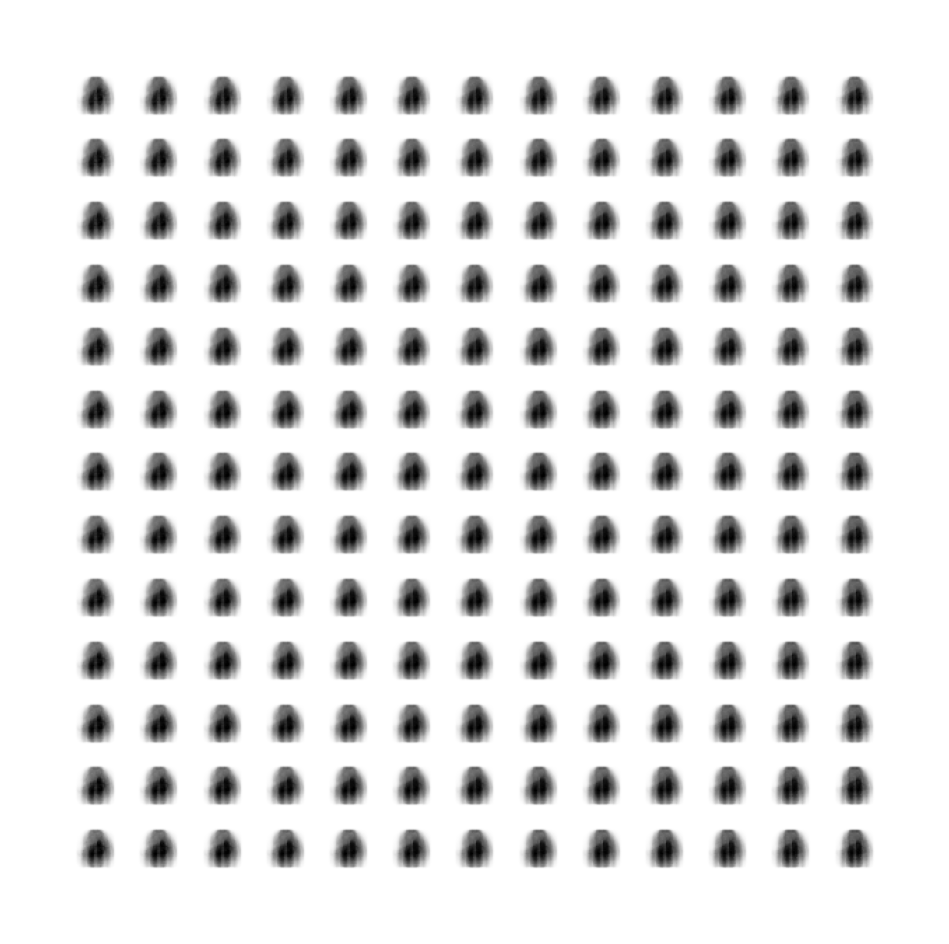

In [50]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = vae.decoder(torch.from_numpy(grid).float()).detach().numpy().reshape(-1, 1, IMAGE_SIZE, IMAGE_SIZE)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, 0, :, :], cmap="Greys")